In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('train.csv', encoding = 'cp949')
test = pd.read_csv('test.csv',encoding = 'cp949')

In [3]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [4]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 결측치 확인하기
print('train 결측치', '\n' ,train.isnull().sum())
print('test 결측치', '\n', test.isnull().sum())

train 결측치 
 num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64
test 결측치 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


- test에 엄청 많은 결측치가 포함되어있다.

In [6]:
# 데이터 타입확인하기
print('train.shape',train.shape)
print('test.shape', test.shape)

train.shape (122400, 10)
test.shape (10080, 9)


## 종속변수 확인해보기

In [7]:
# 전력사용량(kWh)로 표시해주기 너무 불편함으로 target이라고 바꿔주자.
train=train.rename(columns = {'전력사용량(kWh)': 'target'})

Text(0.5, 1.0, 'boxenplot of target')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


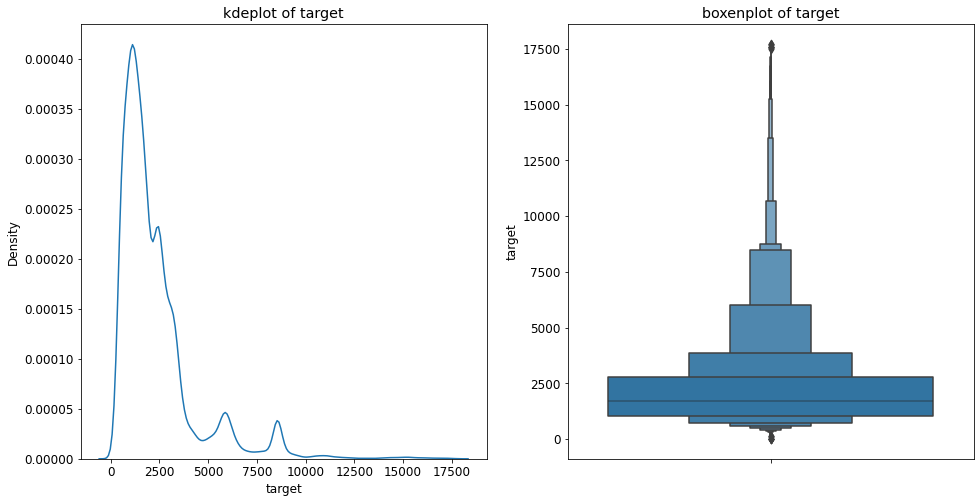

In [8]:
# 정규화가 되어있지 않고 1000~2500까지 많은데이터가 분포되어잇다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.kdeplot(data = train, x = 'target', ax = ax[0])
ax[0].set_title('kdeplot of target')

sns.boxenplot(data = train, y = 'target', ax = ax[1])
ax[1].set_title('boxenplot of target')

- 이상치가 많은것으로 보여진다.

## num(한 건물을 나타낸다.)

In [9]:
train.num.unique()
# 60개의 건물이 있다는 것을 확인했다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

<AxesSubplot:xlabel='num', ylabel='target'>

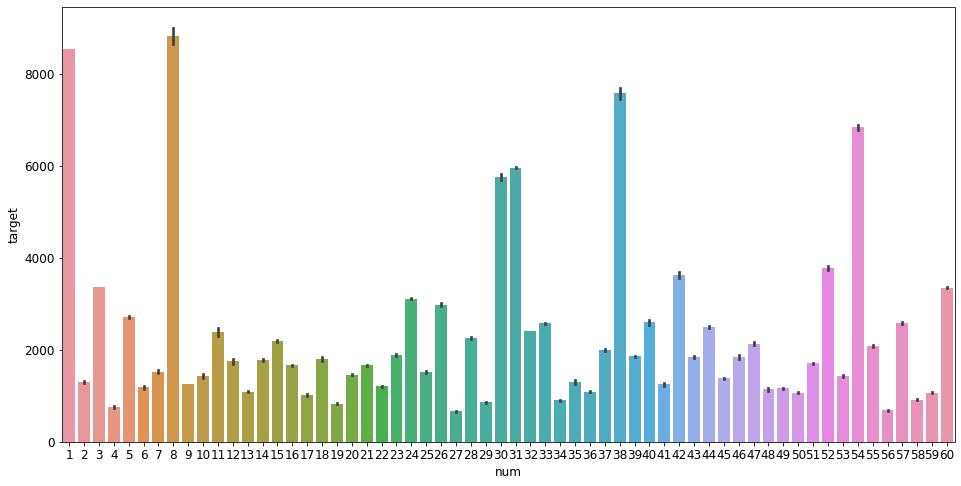

In [10]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'num', y = 'target')

- 각 건물마다 전기 사용량이 제각각 다른 것을 확인했다.

## date_time

In [11]:
# 월, 일, 시간 별로 나누는 함수 만들기
def date_time(df, columns = 'date_time'):
    df['month'] = df[columns].apply(lambda x: x[5:7])
    df['day'] = df[columns].apply(lambda x:x[8:10])
    df['hour'] = df[columns].apply(lambda x:x[11:])
    return df
# train데이터에 적용시켜주기
train = date_time(train)

In [12]:
# 평일과 공휴일 함수 만들기
def weekday(df, columns = 'date_time'):
    df[columns]=pd.to_datetime(df[columns])
    df['weekday'] = df[columns].apply(lambda x:x.weekday())
    df['weekday'] = df['weekday'].apply(lambda x:1 if x >4 else 0)
    return df
# 평일과 공휴일 함수 적용시켜주기
train=weekday(df = train)

### 월별 데이터 확인해보기

Text(0.5, 1.0, 'boxnplot - month of target')

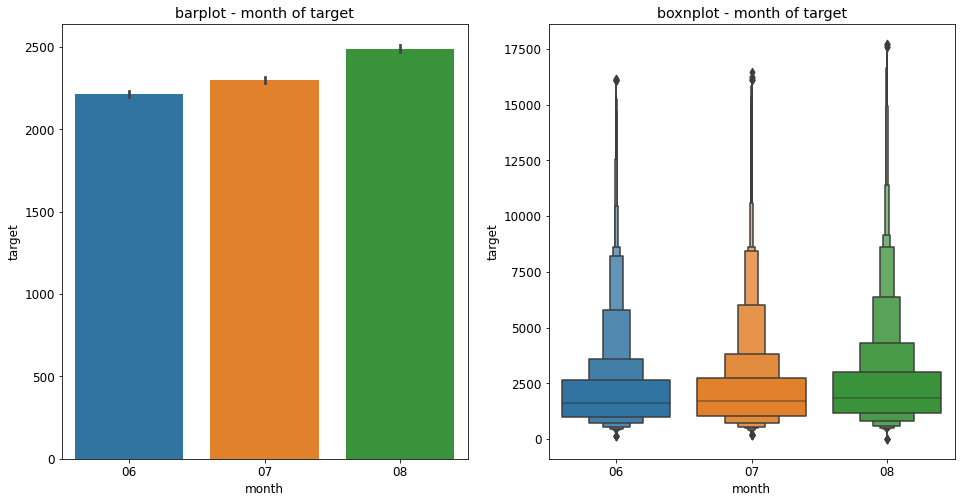

In [13]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('barplot - month of target')

sns.boxenplot(data = train, x= 'month', y = 'target', ax = ax[1])
ax[1].set_title('boxnplot - month of target')

- 시간이 지날수록 더 많은 전력량을 사용하는 것을 알 수 있다.
- 우리는 test값이 8월달의 데이터만 가지고 있기 때문에 어떻게 분석해줄지는 확인해 봐야겠다.

### 일별 확인해 보기

Text(0.5, 1.0, 'boxenplot - day of target')

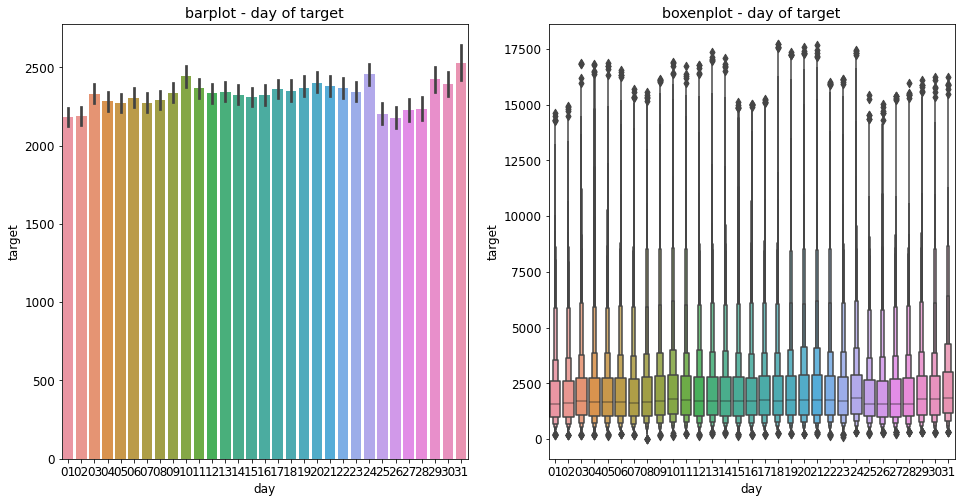

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', ax = ax[0])
ax[0].set_title('barplot - day of target')

sns.boxenplot(data = train, x = 'day', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - day of target')

- 일별로 큰 차이가 있다고 말 할수는 없을 것 같다

### 시간별 확인해 보기

Text(0.5, 1.0, 'boxenplot - hour of target')

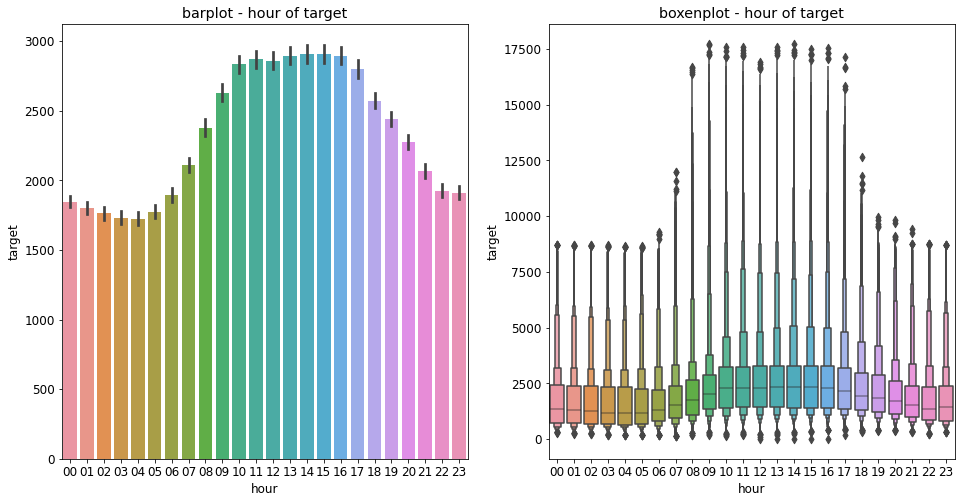

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', ax = ax[0])
ax[0].set_title('barplot - hour of target')

sns.boxenplot(data = train, x = 'hour', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - hour of target')

- 시간별로 확실한 차이가 있다고 말할 수 있다.
- 사람들이 활동하는 시간에 전력소모량이 가장 많은 것을 알 수 있다.

### 평일과 주말로 비교해보기

Text(0.5, 1.0, 'boxenplot of weekday')

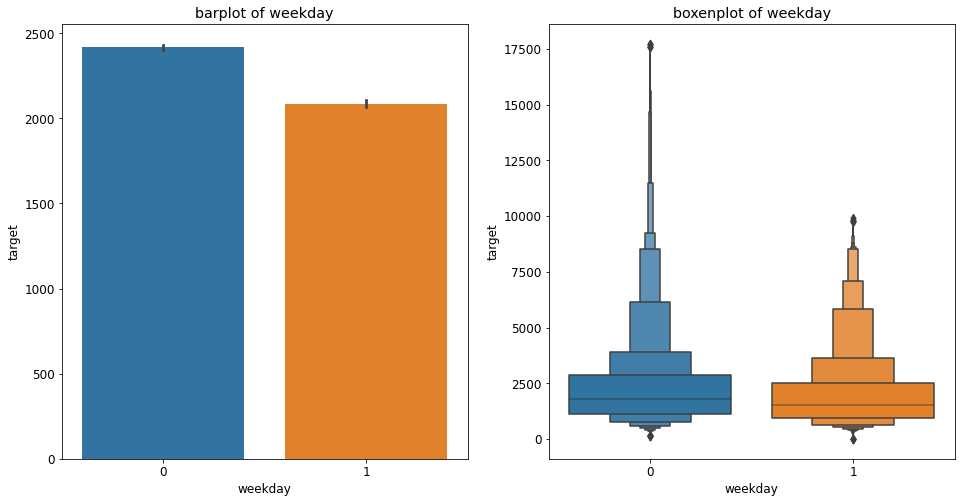

In [16]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('barplot of weekday')

sns.boxenplot(data = train, x = 'weekday', y  ='target', ax = ax[1])
ax[1].set_title('boxenplot of weekday')

- 평일에 많은 전력량을 소모하는 것으로 나타낸다.

Text(0.5, 1.0, 'weekday month target')

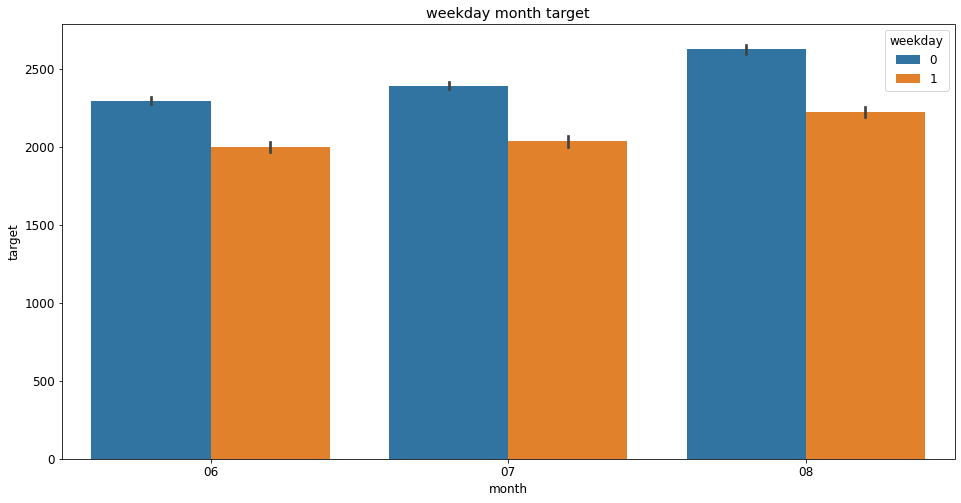

In [17]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', hue = 'weekday')
plt.title('weekday month target')

Text(0.5, 1.0, 'weekday day target')

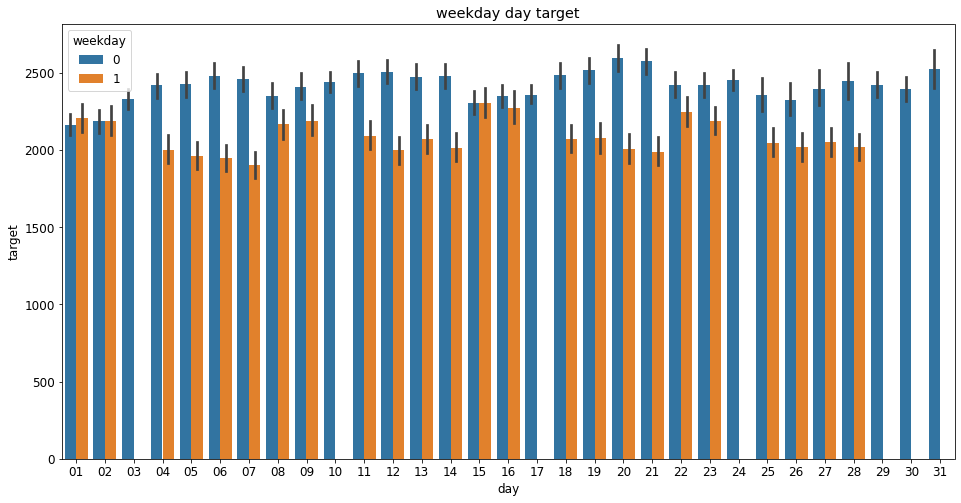

In [18]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', hue = 'weekday')
plt.title('weekday day target')

- 주말이 없는 날짜가 있기 때문에 표시가 안된 부분도 있다.

Text(0.5, 1.0, 'weekday hour target')

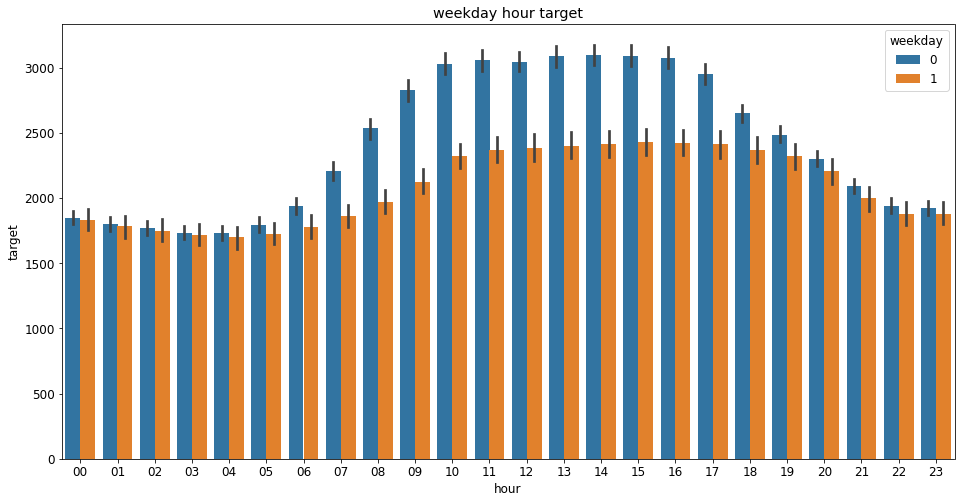

In [19]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')
plt.title('weekday hour target')

## 기온

In [20]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
train=train.rename(columns = {'기온(°C)':'기온', '풍속(m/s)':'풍속',
                              '습도(%)':'습도',
                              '강수량(mm)':'강수량','일조(hr)':'일조'})

In [21]:
# min = 11.1, max = 36.3
train['기온'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: 기온, dtype: float64

<AxesSubplot:xlabel='기온', ylabel='Density'>

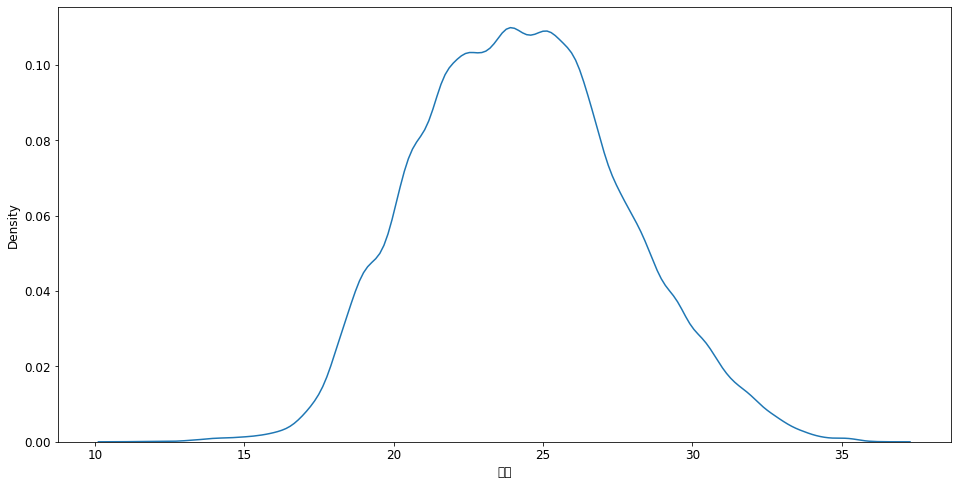

In [22]:
sns.kdeplot(data = train, x = '기온')